In [1]:
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [33]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50



In [5]:
import zipfile
import os


zip_path = "dataset.zip"
extract_path = "/content/face-mask-dataset"


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)


✅ Dataset extracted to: /content/face-mask-dataset


In [9]:
from pathlib import Path


data_dir = Path("/content/face-mask-dataset/data")


for cls in data_dir.iterdir():
    if cls.is_dir():
        print(f" {cls.name}: {len(list(cls.glob('*')))} images")


 without_mask: 3828 images
 with_mask: 3725 images



 Class: without_mask — showing 3 sample images


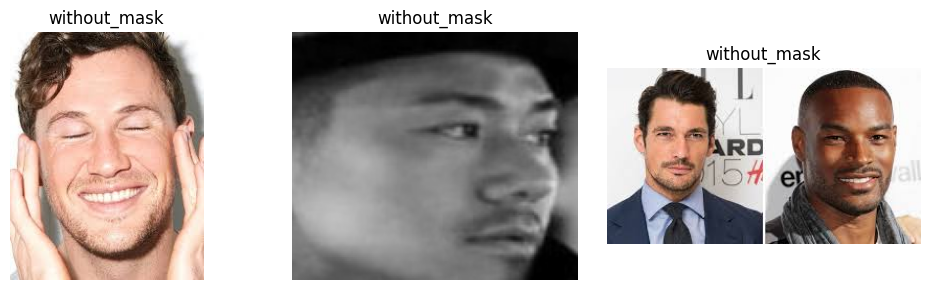


 Class: with_mask — showing 3 sample images


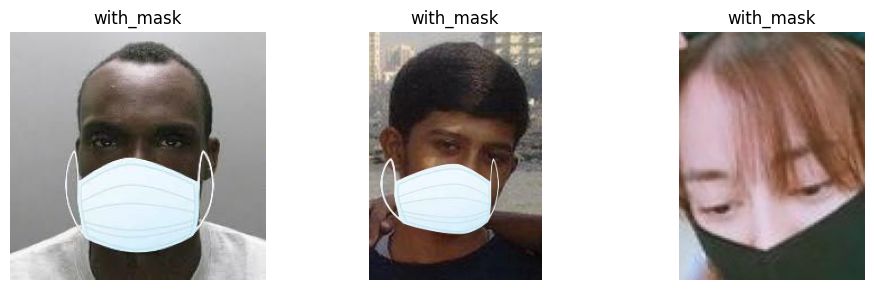

In [12]:

class_folders = [f for f in data_dir.iterdir() if f.is_dir()]

for cls in class_folders:
    image_files = list(cls.glob("*.png")) + list(cls.glob("*.jpg"))
    print(f"\n Class: {cls.name} — showing {min(len(image_files), 3)} sample images")

    plt.figure(figsize=(10, 3))
    for i, img_path in enumerate(image_files[:3]):
        img = mpimg.imread(img_path)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls.name)
    plt.tight_layout()
    plt.show()


In [13]:
class_counts = {
    cls.name: len(list(cls.glob("*.*")))
    for cls in data_dir.iterdir() if cls.is_dir()
}


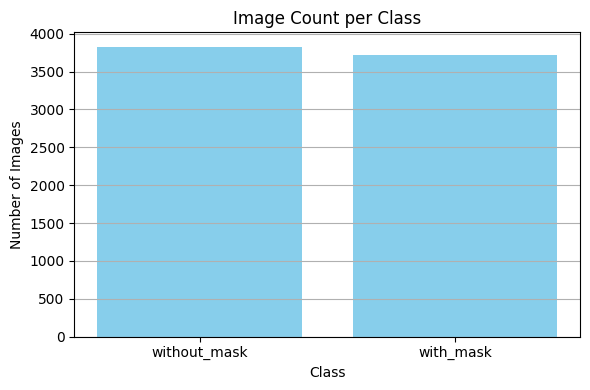

In [14]:
plt.figure(figsize=(6,4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [16]:

img_size = (224, 224)
batch_size = 32



datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Training data
train_gen = datagen.flow_from_directory(
    directory=data_dir.as_posix(),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation data
val_gen = datagen.flow_from_directory(
    directory=data_dir.as_posix(),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


In [19]:
#Simple CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cnn = cnn_model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[early_stop]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/189 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.6754 - loss: 0.7377

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 31s 123ms/step - accuracy: 0.7364 - loss: 0.6049 - val_accuracy: 0.8543 - val_loss: 0.3490
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.8861 - loss: 0.2789 - val_accuracy: 0.9179 - val_loss: 0.2200
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9145 - loss: 0.2064 - val_accuracy: 0.9265 - val_loss: 0.2147
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9338 - loss: 0.1687 - val_accuracy: 0.9358 - val_loss: 0.1814
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9547 - loss: 0.1196 - val_accuracy: 0.9503 - val_loss: 0.1484
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.9653 - loss: 0.0899 - val_accuracy: 0.9318 - val_loss: 0.2084
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.9769 - loss: 0.0619 - val_accuracy: 0.9265 - val_loss: 0.2293
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.9804 - loss: 0.0561 - val_accur

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


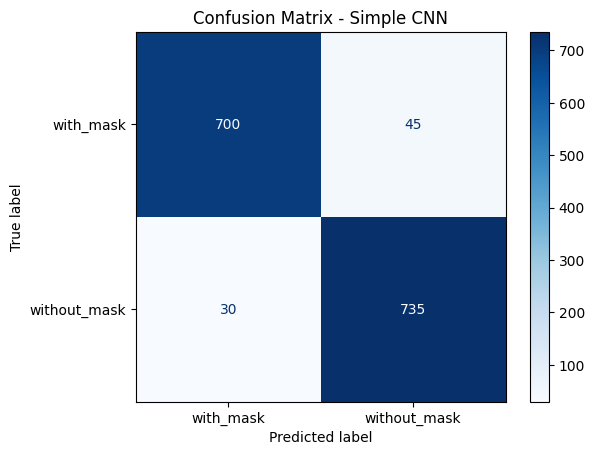

In [26]:
val_gen.reset()
y_true = val_gen.classes
y_pred = cnn_model.predict(val_gen)
y_pred = (y_pred > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices.keys())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Simple CNN")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


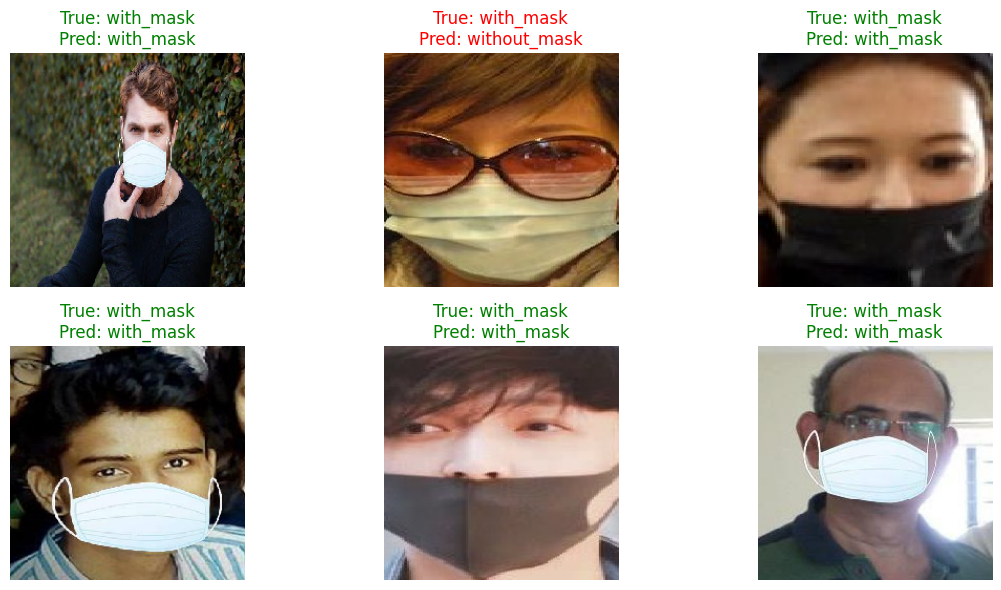

In [25]:
class_labels = list(val_gen.class_indices.keys())


val_gen.reset()
x, y = next(val_gen)

preds = cnn_model.predict(x)
preds = (preds > 0.5).astype(int).flatten()

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x[i])
    true_label = class_labels[int(y[i])]
    pred_label = class_labels[int(preds[i])]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [28]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

mobilenet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

mobilenet_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_mobilenet = mobilenet_model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[early_stop]
)

Epoch 1/10
 81/189 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9092 - loss: 0.2046

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - accuracy: 0.9411 - loss: 0.1381 - val_accuracy: 0.9868 - val_loss: 0.0419
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.9905 - loss: 0.0277 - val_accuracy: 0.9874 - val_loss: 0.0353
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9947 - loss: 0.0157 - val_accuracy: 0.9887 - val_loss: 0.0420
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.9971 - loss: 0.0092 - val_accuracy: 0.9801 - val_loss: 0.0663
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.9979 - loss: 0.0062 - val_accuracy: 0.9841 - val_loss: 0.0508


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step


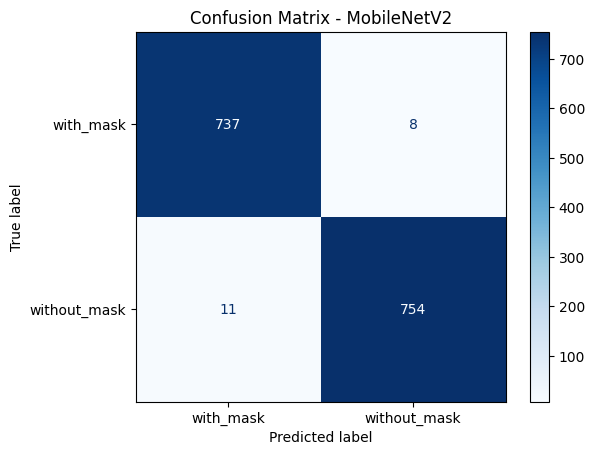

In [30]:
val_gen.reset()
y_true = val_gen.classes
y_pred_mobilenet = mobilenet_model.predict(val_gen)
y_pred_mobilenet = (y_pred_mobilenet > 0.5).astype(int).flatten()

cm = confusion_matrix(y_true, y_pred_mobilenet)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices.keys())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - MobileNetV2")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


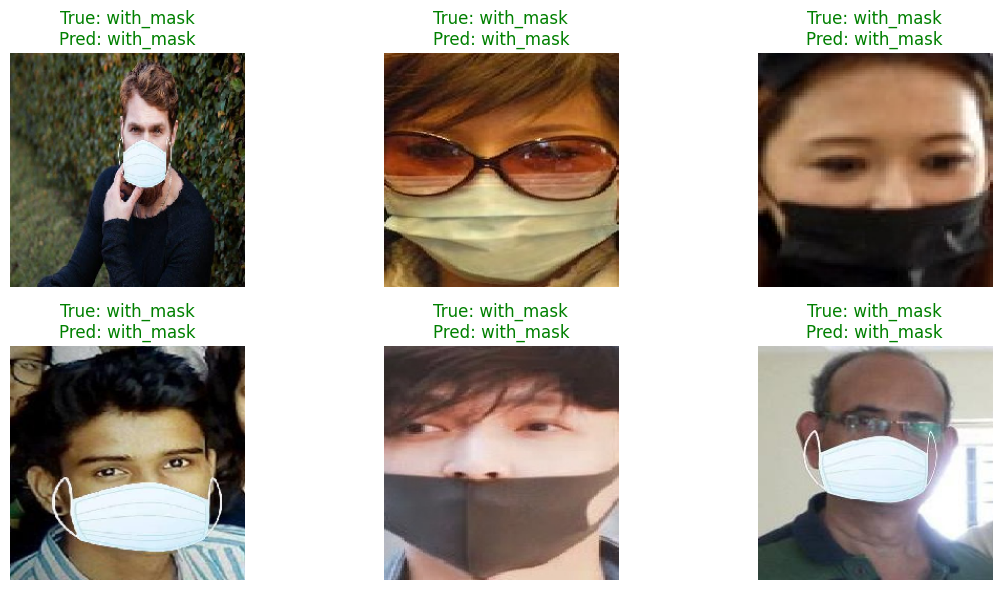

In [31]:
class_labels = list(val_gen.class_indices.keys())

val_gen.reset()
x_val, y_val = next(val_gen)

preds = mobilenet_model.predict(x_val)
preds = (preds > 0.5).astype(int).flatten()

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_val[i])
    true_label = class_labels[int(y_val[i])]
    pred_label = class_labels[int(preds[i])]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [34]:
resnet_base = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
resnet_base.trainable = False


resnet_model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

resnet_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [35]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_resnet = resnet_model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[early_stop]
)

Epoch 1/10
 41/189 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.5219 - loss: 0.7942

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 50s 177ms/step - accuracy: 0.5705 - loss: 0.7075 - val_accuracy: 0.4974 - val_loss: 0.7045
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.6265 - loss: 0.6444 - val_accuracy: 0.5523 - val_loss: 0.7302
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.6372 - loss: 0.6349 - val_accuracy: 0.5430 - val_loss: 0.6898
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6479 - loss: 0.6230 - val_accuracy: 0.5675 - val_loss: 0.6958
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.6642 - loss: 0.6166 - val_accuracy: 0.5768 - val_loss: 0.6679
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.6580 - loss: 0.6135 - val_accuracy: 0.5834 - val_loss: 0.6631
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.6802 - loss: 0.6046 - val_accuracy: 0.6464 - val_loss: 0.6636
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.6729 - loss: 0.5985 - val

In [37]:

val_gen.reset()
y_true = val_gen.classes


preds_cnn = (cnn_model.predict(val_gen) > 0.5).astype(int).flatten()
val_gen.reset()
preds_mobilenet = (mobilenet_model.predict(val_gen) > 0.5).astype(int).flatten()
val_gen.reset()
preds_resnet = (resnet_model.predict(val_gen) > 0.5).astype(int).flatten()



48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step


In [38]:
from sklearn.metrics import accuracy_score, classification_report


acc_cnn = accuracy_score(y_true, preds_cnn)
acc_mobilenet = accuracy_score(y_true, preds_mobilenet)
acc_resnet = accuracy_score(y_true, preds_resnet)

print(" Accuracy Scores")
print(f"Simple CNN:       {acc_cnn:.4f}")
print(f"MobileNetV2:      {acc_mobilenet:.4f}")
print(f"ResNet50:         {acc_resnet:.4f}")


 Accuracy Scores
Simple CNN:       0.9503
MobileNetV2:      0.9874
ResNet50:         0.6179


In [39]:

val_gen.reset()
probs_cnn = cnn_model.predict(val_gen)

val_gen.reset()
probs_mobilenet = mobilenet_model.predict(val_gen)

val_gen.reset()
probs_resnet = resnet_model.predict(val_gen)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step


In [40]:

ensemble_probs = (probs_cnn + probs_mobilenet + probs_resnet) / 3.0

ensemble_preds = (ensemble_probs > 0.5).astype(int).flatten()


 Ensemble Accuracy: 0.9834

 Classification Report - Ensemble
              precision    recall  f1-score   support

   with_mask       0.99      0.98      0.98       745
without_mask       0.98      0.99      0.98       765

    accuracy                           0.98      1510
   macro avg       0.98      0.98      0.98      1510
weighted avg       0.98      0.98      0.98      1510



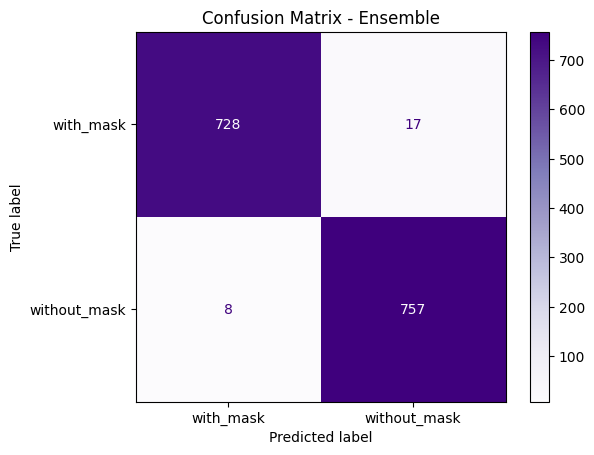

In [41]:
y_true = val_gen.classes


ensemble_acc = accuracy_score(y_true, ensemble_preds)
print(f" Ensemble Accuracy: {ensemble_acc:.4f}")


print("\n Classification Report - Ensemble")
print(classification_report(y_true, ensemble_preds, target_names=val_gen.class_indices.keys()))

cm = confusion_matrix(y_true, ensemble_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices.keys())
disp.plot(cmap='Purples')
plt.title("Confusion Matrix - Ensemble")
plt.show()

In [42]:


summary = pd.DataFrame({
    "Model": ["Simple CNN", "MobileNetV2", "ResNet50", "Ensemble"],
    "Accuracy": [acc_cnn, acc_mobilenet, acc_resnet, ensemble_acc]
})
display(summary)


,Model,Accuracy
0,Simple CNN,0.950331
1,MobileNetV2,0.987417
2,ResNet50,0.617881
3,Ensemble,0.983444


In [43]:
cnn_model.save("cnn_model.h5")
mobilenet_model.save("mobilenet_model.h5")
resnet_model.save("resnet_model.h5")


In [48]:
cnn_model = tf.keras.models.load_model("cnn_model.h5")
mobilenet_model = tf.keras.models.load_model("mobilenet_model.h5")
resnet_model = tf.keras.models.load_model("resnet_model.h5")

# Class map
class_map = {0: "Without Mask", 1: "With Mask"}

def ensemble_predict(img):

    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)


    pred_cnn = cnn_model.predict(img_array)[0][0]
    pred_mobilenet = mobilenet_model.predict(img_array)[0][0]
    pred_resnet = resnet_model.predict(img_array)[0][0]


    avg_pred = (pred_cnn + pred_mobilenet + pred_resnet) / 3
    label = 1 if avg_pred < 0.5 else 0

    return class_map[label]


In [50]:
print(val_gen.class_indices)


{'with_mask': 0, 'without_mask': 1}


In [49]:
import gradio as gr

gr.Interface(
    fn=ensemble_predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="🧠 Face Mask Classifier (Ensemble of 3 Models)",
    description="Upload a face image to check if a person is wearing a mask using an ensemble of CNN, MobileNetV2, and ResNet50."
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fcf57d010e1adf8bdc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [46]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 127.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.3 MB/s eta 0:00:00
